In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

df = pd.read_csv("./diabetes.csv")
df.sample(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
119,4,99,76,15,51,23.2,0.223,21,0
559,11,85,74,0,0,30.1,0.300,35,0
66,0,109,88,30,0,32.5,0.855,38,1
250,9,106,52,0,0,31.2,0.380,42,0
495,6,166,74,0,0,26.6,0.304,66,0
135,2,125,60,20,140,33.8,0.088,31,0
613,6,105,80,28,0,32.5,0.878,26,0
188,8,109,76,39,114,27.9,0.640,31,1
714,3,102,74,0,0,29.5,0.121,32,0
49,7,105,0,0,0,0.0,0.305,24,0


### EDA

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### Remove outliers using IQR method

In [4]:
def remove_outliers(df, out_cols, T=1.5, verbose=True):
    # Copy of df
    new_df = df.copy()
    init_shape = new_df.shape
    
    # For each column
    for c in out_cols:
        q1 = new_df[c].quantile(.25)
        q3 = new_df[c].quantile(.75)
        col_iqr = q3 - q1
        col_max = q3 + T * col_iqr
        col_min = q1 - T * col_iqr
        
        # Filter data without outliers and ignoring nan
        filtered_df = new_df[(new_df[c] <= col_max) & (new_df[c] >= col_min)]
        if verbose:
            n_out = new_df.shape[0] - filtered_df.shape[0] 
            print(f" Columns {c} had {n_out} outliers removed")
        new_df = filtered_df
            
    if verbose:
        # Print shrink percentage
        lines_red = df.shape[0] - new_df.shape[0]
        print(f"Data reduced by {lines_red} lines, or {lines_red/df.shape[0]*100:.2f} %")
    
    return new_df

df = remove_outliers(df, ["Glucose", "Pregnancies", "BloodPressure", "SkinThickness", "Insulin", "BMI", "Age"])

 Columns Glucose had 5 outliers removed
 Columns Pregnancies had 4 outliers removed
 Columns BloodPressure had 45 outliers removed
 Columns SkinThickness had 1 outliers removed
 Columns Insulin had 27 outliers removed
 Columns BMI had 10 outliers removed
 Columns Age had 7 outliers removed
Data reduced by 99 lines, or 12.89 %


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

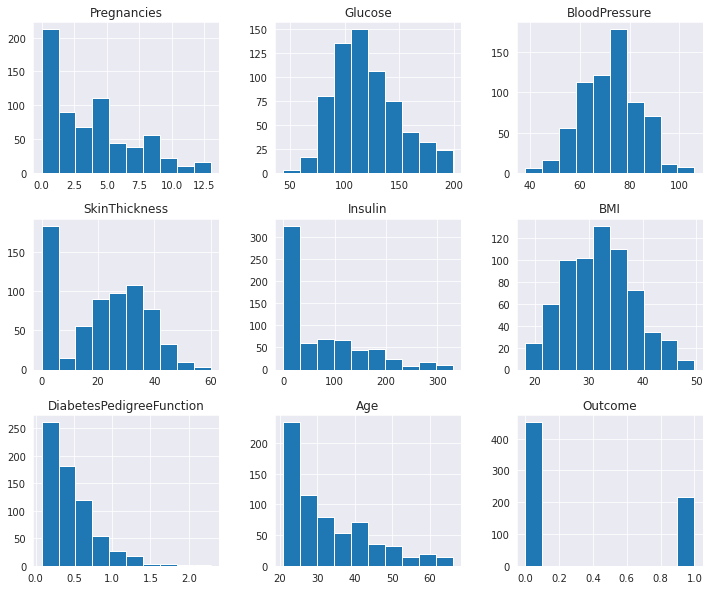

In [6]:
df.hist(figsize=(12, 10))

In [7]:
df_02 = df.copy(deep=True)
df_02.iloc[:, :-1] = df_02.iloc[:, :-1].replace(0, np.NaN)
df_02.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148,72,35.0,NaN,33.6,0.627,50,1
1,1.0,85,66,29.0,NaN,26.6,0.351,31,0
2,8.0,183,64,NaN,NaN,23.3,0.672,32,1
3,1.0,89,66,23.0,94.0,28.1,0.167,21,0
4,NaN,137,40,35.0,168.0,43.1,2.288,33,1


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

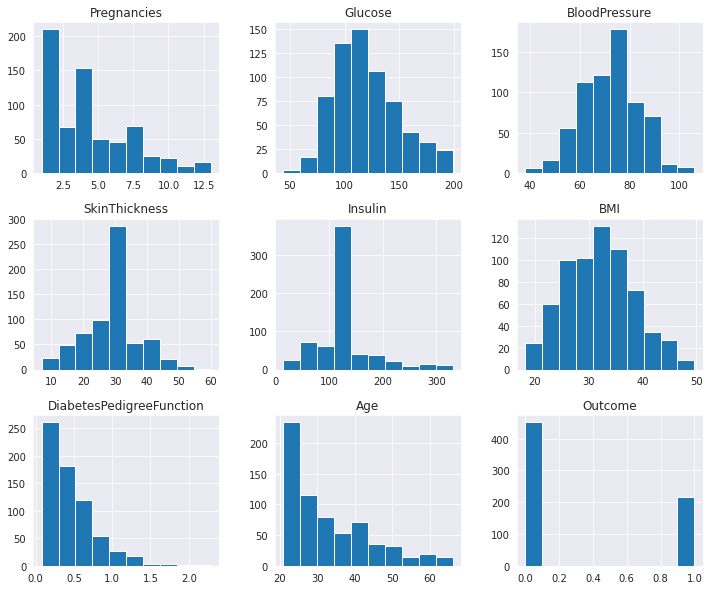

In [8]:
x = df_02.columns[:-1]

for c in x:
    df_02[c].fillna(df_02[c].mean(), inplace=True)
    
df_02.hist(figsize=(12, 10))

<AxesSubplot:>

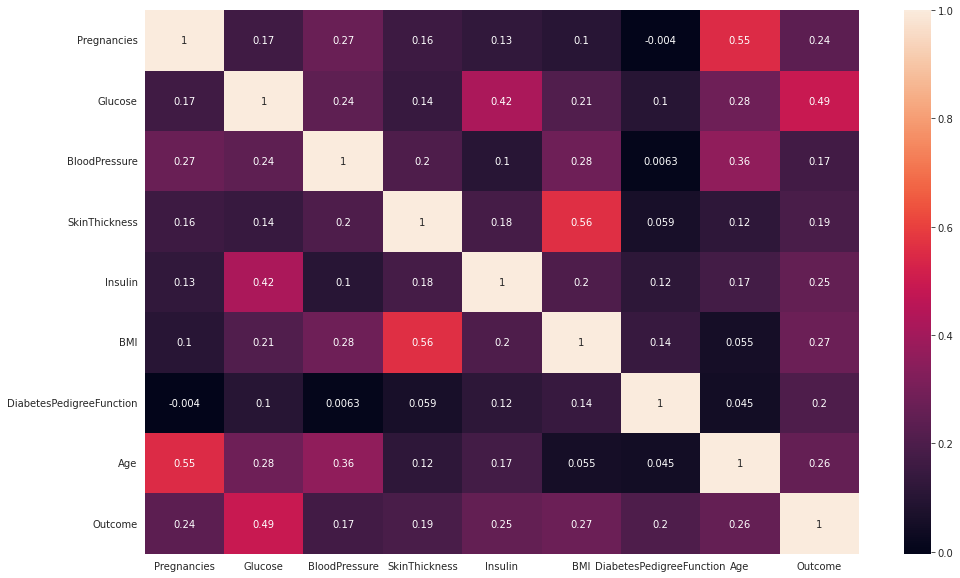

In [9]:
# correlations in data
df_corr = df_02.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(df_corr, annot=True)

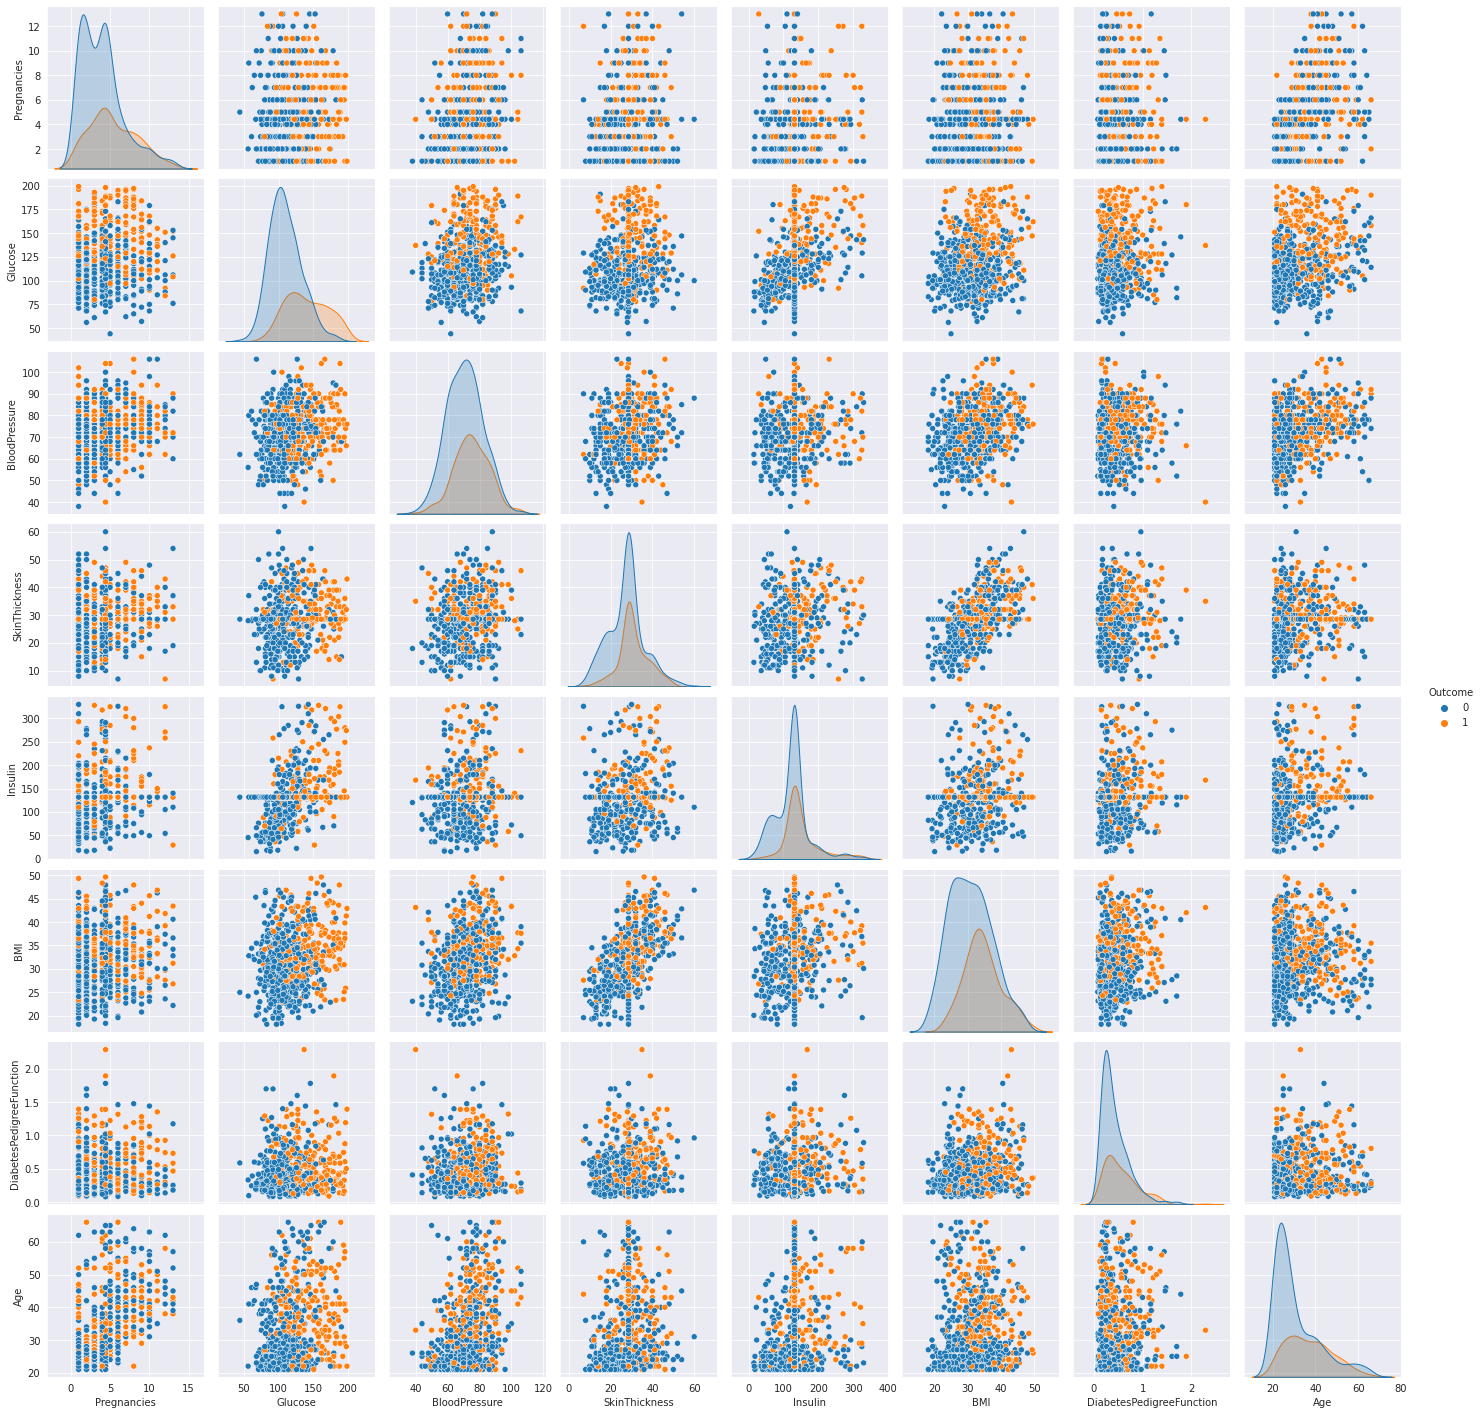

In [10]:
sns.pairplot(df_02, hue='Outcome')

In [11]:
# For a distance based analysis like KNN, we need ensure the weight distribution among the features 
# is uniform, hence we scale the data

std_sc = StandardScaler()

features = df_02.columns.values[:-1]

# features
X = pd.DataFrame(std_sc.fit_transform(df_02.drop(["Outcome"], axis=1), ), columns=features)

#target
y = df_02.Outcome

In [12]:
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(X, y)
best_features_idx = selector.get_support()
best_features = [features[f]
                for f in range(len(features))
                    if best_features_idx[f]]
best_features

['Glucose', 'Insulin', 'BMI', 'Age']

In [13]:
df_op = df_02[['Glucose', 'Insulin', 'BMI', 'Age', 'Outcome']]


# a copy for hyperparameter tuning
df_copy = df_op.copy(deep=True)
X_op_copy = pd.DataFrame(std_sc.fit_transform(df_copy.drop(["Outcome"], axis=1), ), columns=best_features)
y_op_copy = df_copy.Outcome
X_train, X_test, y_train, y_test = train_test_split(X_op_copy, y_op_copy, 
                                                    test_size=0.15, 
                                                    random_state=100,
                                                   stratify=y)

In [14]:
def calculate_model_accuracy(model):
    df_op_final = df_op.copy(deep=True)
    # features
    X_op = pd.DataFrame(std_sc.fit_transform(
                            df_op_final.drop(["Outcome"], axis=1), ), 
                            columns= best_features)

    #target
    y_op = df_op_final.Outcome

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_op, y_op, 
                                                        test_size=0.20,
                                                        stratify=y,
                                                        random_state=24)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Accuracy score: ")
    print(metrics.accuracy_score(y_test, y_pred))
    
    print("\n\nClassification report: ")
    print(metrics.classification_report(y_test, y_pred))
    
    print("\n\nConfusion matrix: ")
    print(metrics.confusion_matrix(y_test, y_pred))
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("\n\nROC AUC score: ")
    print(metrics.roc_auc_score(y_test, y_pred_proba))
    
    def roc_auc_plot(y_test, y_pred_proba):
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
        
        roc_auc = metrics.auc(fpr, tpr)
        
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'*-')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiving Operating Characteristic')
        return roc_auc
    auc = roc_auc_plot(y_test=y_test, y_pred_proba=y_pred_proba)
    
    return tn, fp, fn, tp, auc

# KNN

Accuracy score: 
0.8208955223880597


Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        91
           1       0.79      0.60      0.68        43

    accuracy                           0.82       134
   macro avg       0.81      0.76      0.78       134
weighted avg       0.82      0.82      0.81       134



Confusion matrix: 
[[84  7]
 [17 26]]


ROC AUC score: 
0.8738819320214668


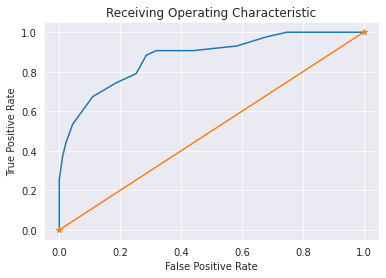

In [15]:
# hyperparameter tuning

# randomsearchCV to find the optimal n_neighbours for KNN
knn = KNeighborsClassifier()

leaf_size_range = list(range(1, 50))
n_neighbors_range = list(range(1, 50))
weight_options = ["uniform", "distance"]
metric_options = ['minkowski','euclidean','manhattan']

param_dist = dict(n_neighbors = n_neighbors_range, 
                  weights = weight_options, 
                  leaf_size=leaf_size_range,
                 metric=metric_options)

rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring="accuracy", random_state=100)

rand.fit(X_train, y_train)

knn_best_params = rand.best_params_

knn = KNeighborsClassifier(**knn_best_params)

tn_knn, fp_knn, fn_knn, tp_knn, auc_knn = calculate_model_accuracy(knn)

# Logistic Regression

/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1

Accuracy score: 
0.8208955223880597


Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        91
           1       0.73      0.70      0.71        43

    accuracy                           0.82       134
   macro avg       0.80      0.79      0.79       134
weighted avg       0.82      0.82      0.82       134



Confusion matrix: 
[[80 11]
 [13 30]]


ROC AUC score: 
0.8648096089956555


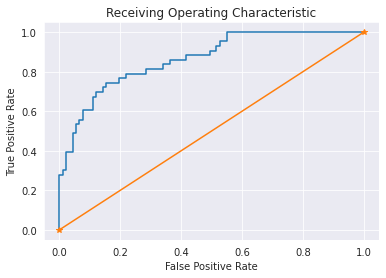

In [16]:
# hyperparameter tuning

from scipy.stats import uniform

log_reg = LogisticRegression(solver='liblinear')

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

rand = RandomizedSearchCV(log_reg, param_grid, cv=10, scoring="accuracy", random_state=100)

rand.fit(X_train, y_train)

lr_best_params = rand.best_params_

log_reg = LogisticRegression(**lr_best_params)

tn_lr, fp_lr, fn_lr, tp_lr, auc_lr = calculate_model_accuracy(log_reg)

total_obs = tn_lr + fp_lr + fn_lr + tp_lr

some hyperparameters don't have compatibility with each other hence the many warnings. We can ignore those as the output is still the optimized hyperparameters considering the once that are imcompatible with each other

<br />

# Decision Tree

/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/py

Accuracy score: 
0.7761194029850746


Classification report: 
              precision    recall  f1-score   support

           0       0.76      0.99      0.86        91
           1       0.93      0.33      0.48        43

    accuracy                           0.78       134
   macro avg       0.84      0.66      0.67       134
weighted avg       0.81      0.78      0.74       134



Confusion matrix: 
[[90  1]
 [29 14]]


ROC AUC score: 
0.7691029900332227


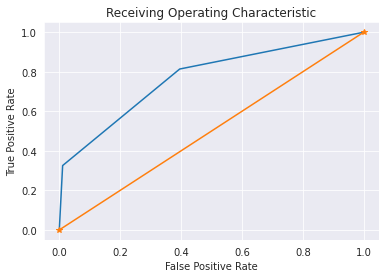

In [17]:
# hyperparameter tuning

max_depth_value = [2, 3, 5, 10, 20, None]
max_features_value =  list(range(1, 10))
min_samples_leaf_value = list(range(1, 100))
criterion_value = ["gini", "entropy"]

param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

dec_tree = DecisionTreeClassifier()

rand = RandomizedSearchCV(dec_tree, param_grid, cv=10, scoring="accuracy", random_state=100)

rand.fit(X_train, y_train)

dt_best_params = rand.best_params_

dec_tree = DecisionTreeClassifier(**dt_best_params)

tn_dt, fp_dt, fn_dt, tp_dt, auc_dt = calculate_model_accuracy(dec_tree)

# Support Vector Machine

Accuracy score: 
0.7611940298507462


Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        91
           1       0.59      0.81      0.69        43

    accuracy                           0.76       134
   macro avg       0.74      0.78      0.75       134
weighted avg       0.80      0.76      0.77       134



Confusion matrix: 
[[67 24]
 [ 8 35]]


ROC AUC score: 
0.855737285969844


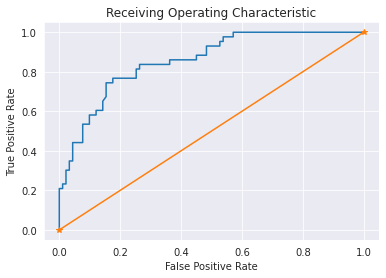

In [18]:
# hyperparameter tuning

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 100, 1000]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
degree_vals = [1,2,3,4,5,6]
gamma_vals = [1, 0.1, 0.01, 0.001, 0.0001]
seed_val = [100]

param_grid = dict(C=c_values, 
                  kernel=kernel_values,
                 degree = degree_vals,
                 gamma=gamma_vals,
                 random_state=seed_val)


svc = SVC(probability=False)

rand = RandomizedSearchCV(svc, param_grid, cv=10, scoring="accuracy", random_state=100)

rand.fit(X_train, y_train)

svc_best_params = rand.best_params_

svc = SVC(class_weight='balanced', probability=True, **svc_best_params)

tn_svm, fp_svm, fn_svm, tp_svm, auc_svm = calculate_model_accuracy(svc)

# Random Forest

Accuracy score: 
0.7611940298507462


Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        91
           1       0.68      0.49      0.57        43

    accuracy                           0.76       134
   macro avg       0.73      0.69      0.70       134
weighted avg       0.75      0.76      0.75       134



Confusion matrix: 
[[81 10]
 [22 21]]


ROC AUC score: 
0.8377204191157679


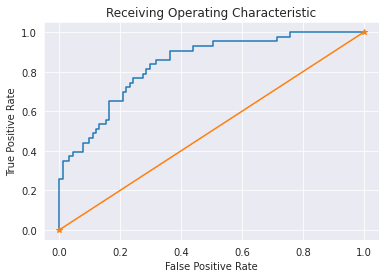

In [19]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier()

rand = RandomizedSearchCV(rfc, param_grid, cv=10, scoring="accuracy", random_state=100)

rand.fit(X_train, y_train)

rf_best_params = rand.best_params_

rfc = RandomForestClassifier(**rf_best_params)

tn_rfc, fp_rfc, fn_rfc, tp_rfc, auc_rfc = calculate_model_accuracy(rfc)

# Performance Report

In [20]:
performance_mapping = {
    'Classifier': ['ROC AUC (%)', 'TN (%)','FP (%)','FN (%)','TP (%)'],
    'Logistic Regression': [(auc_lr*100).round(2), 
                            ((tn_lr/total_obs)*100).round(2),
                           ((fp_lr/total_obs)*100).round(2), 
                           ((fn_lr/total_obs)*100).round(2),
                           ((tp_lr/total_obs)*100).round(2)],
    'KNN': [(auc_knn*100).round(2), 
            ((tn_knn/total_obs)*100).round(2),
                           ((fp_knn/total_obs)*100).round(2), 
                           ((fn_knn/total_obs)*100).round(2),
                           ((tp_knn/total_obs)*100).round(2)],
    'Decision Tree': [(auc_dt*100).round(2), 
                      ((tn_dt/total_obs)*100).round(2),
                           ((fp_dt/total_obs)*100).round(2), 
                           ((fn_dt/total_obs)*100).round(2),
                           ((tp_dt/total_obs)*100).round(2)],
    'Support Vector Machine': [(auc_svm*100).round(2), 
                               ((tn_svm/total_obs)*100).round(2),
                           ((fp_svm/total_obs)*100).round(2), 
                           ((fn_svm/total_obs)*100).round(2),
                           ((tp_svm/total_obs)*100).round(2)],
    'Random Forest': [(auc_rfc*100).round(2), 
                      ((tn_rfc/total_obs)*100).round(2),
                           ((fp_rfc/total_obs)*100).round(2), 
                           ((fn_rfc/total_obs)*100).round(2),
                           ((tp_rfc/total_obs)*100).round(2)]
}

df_results = pd.DataFrame(performance_mapping, 
                          columns=['Classifier', 
                                   'Logistic Regression',
                                   'KNN',
                                   'Decision Tree',
                                   'Support Vector Machine',
                                   'Random Forest'
                                ])
df_results.set_index("Classifier", inplace=True)
results = df_results.T
results

Classifier,ROC AUC (%),TN (%),FP (%),FN (%),TP (%)
Logistic Regression,86.48,59.70,8.21,9.70,22.39
KNN,87.39,62.69,5.22,12.69,19.40
Decision Tree,76.91,67.16,0.75,21.64,10.45
Support Vector Machine,85.57,50.00,17.91,5.97,26.12
Random Forest,83.77,60.45,7.46,16.42,15.67


KNN has the highest prediction accuracy

But we'll use Support Vector Machines as it has the lowest False Negative rate. We cannot afford to not detect the patients who have diabetes for higher model accuracy, hence we'll tolerate a drop of 1.82% in prediction to increase fase negative rate by 6.72%.

In [25]:
svc_best_params

{'random_state': 100, 'kernel': 'linear', 'gamma': 1, 'degree': 3, 'C': 0.5}